In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set(rc={"figure.figsize": (12, 6)})
except ImportError:
    print('We suggest you install seaborn using conda or pip and rerun this cell')

# built in python modules
import datetime
import logging
import os
import inspect

# python add-ons
import numpy as np
import pandas as pd

In [8]:
import pvlib
from pvlib.location import Location
from pvlib.tools import cosd, sind

In [9]:
tus = Location(20.2961, 85.8245, 'Asia/Kolkata', 45, 'BBSR')
johannesburg = Location(28.7041, 77.1025, 'Asia/Kolkata',216, 'Delhi')

                           apparent_elevation  apparent_azimuth  elevation  \
2015-06-24 00:00:00+05:30          -46.202453          3.674457 -46.202453   
2015-06-24 00:01:00+05:30          -46.186764          4.005030 -46.186764   
2015-06-24 00:02:00+05:30          -46.169726          4.335364 -46.169726   
2015-06-24 00:03:00+05:30          -46.151342          4.665442 -46.151342   
2015-06-24 00:04:00+05:30          -46.131610          4.995243 -46.131610   

                            azimuth  apparent_zenith      zenith  
2015-06-24 00:00:00+05:30  3.674457       136.202453  136.202453  
2015-06-24 00:01:00+05:30  4.005030       136.186764  136.186764  
2015-06-24 00:02:00+05:30  4.335364       136.169726  136.169726  
2015-06-24 00:03:00+05:30  4.665442       136.151342  136.151342  
2015-06-24 00:04:00+05:30  4.995243       136.131610  136.131610  


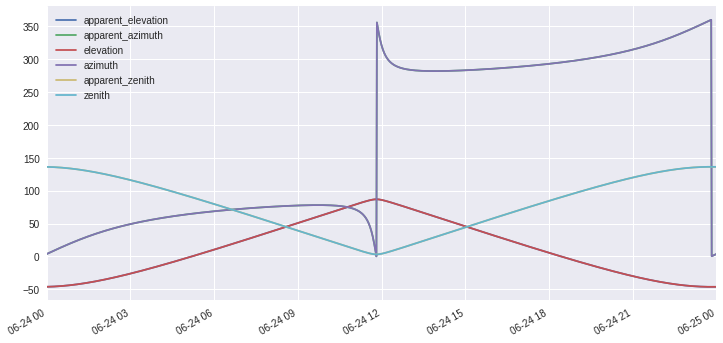

In [10]:
times = pd.date_range(start=datetime.datetime(2015,6,24), end=datetime.datetime(2015,6,25), freq='1Min', tz=tus.tz)

pyephem_ephem = pvlib.solarposition.get_solarposition(times, tus.latitude, tus.longitude, method='pyephem')
print(pyephem_ephem.head())
pyephem_ephem.plot()

In [11]:
times = pd.date_range(start=datetime.datetime(2014,3,23), end=datetime.datetime(2014,3,24), freq='5Min')

ephem_tus = pvlib.solarposition.get_solarposition(times.tz_localize(tus.tz), tus.latitude, tus.longitude)
ephem_joh = pvlib.solarposition.get_solarposition(times.tz_localize(johannesburg.tz),
                                                  johannesburg.latitude, johannesburg.longitude)
ephemout = ephem_tus

In [12]:
azimuth = ephemout['azimuth']
apparent_azimuth = ephemout['azimuth']
apparent_zenith = ephemout['apparent_zenith']
axis_tilt = 10
axis_azimuth = 170
latitude = 32
max_angle = 65 
backtrack = True
gcr = 2.0/7.0

times = azimuth.index

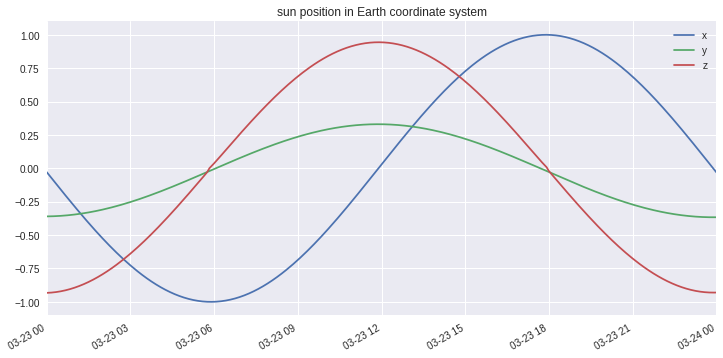

In [13]:
az = apparent_azimuth - 180
apparent_elevation = 90 - apparent_zenith
x = cosd(apparent_elevation) * sind(az)
y = cosd(apparent_elevation) * cosd(az)
z = sind(apparent_elevation)

earth_coords = pd.DataFrame({'x':x,'y':y,'z':z})

earth_coords.plot()
plt.title('sun position in Earth coordinate system')

cos(axis_azimuth_south)=0.984807753012208, sin(axis_azimuth_south)=-0.17364817766693033
cos(axis_tilt)=0.984807753012208, sin(axis_tilt)=0.17364817766693033


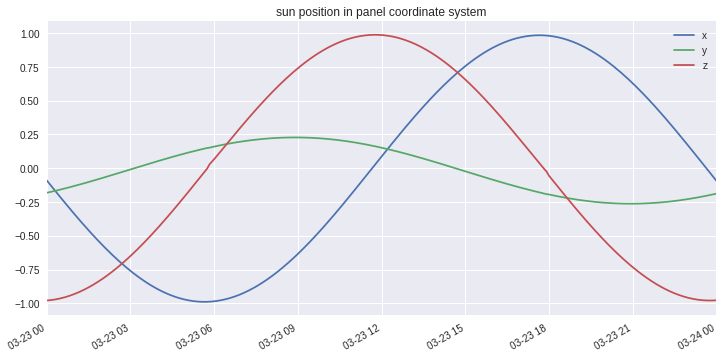

In [14]:
axis_azimuth_south = axis_azimuth - 180

print('cos(axis_azimuth_south)={}, sin(axis_azimuth_south)={}'
      .format(cosd(axis_azimuth_south), sind(axis_azimuth_south)))
print('cos(axis_tilt)={}, sin(axis_tilt)={}'
      .format(cosd(axis_tilt), sind(axis_tilt)))

xp = x*cosd(axis_azimuth_south) - y*sind(axis_azimuth_south);
yp = (x*cosd(axis_tilt)*sind(axis_azimuth_south) +
      y*cosd(axis_tilt)*cosd(axis_azimuth_south) -
      z*sind(axis_tilt))
zp = (x*sind(axis_tilt)*sind(axis_azimuth_south) +
      y*sind(axis_tilt)*cosd(axis_azimuth_south) +
      z*cosd(axis_tilt))

panel_coords = pd.DataFrame({'x':xp,'y':yp,'z':zp})

panel_coords.plot()
plt.title('sun position in panel coordinate system')

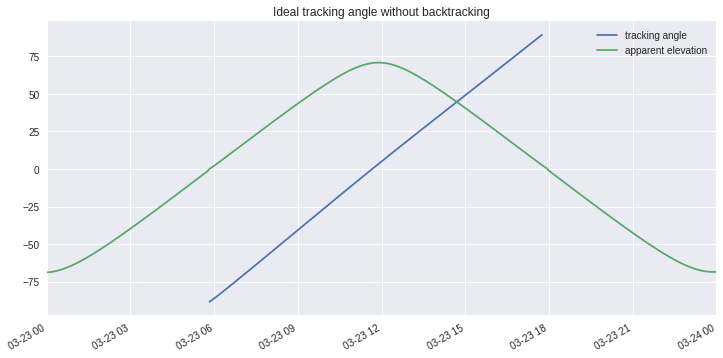

In [15]:
wid = pd.Series(90 - np.degrees(np.arctan2(zp, xp)), index=times)

# filter for sun above panel horizon
wid[zp <= 0] = np.nan

wid.plot(label='tracking angle')
ephemout['apparent_elevation'].plot(label='apparent elevation')
plt.legend()
plt.title('Ideal tracking angle without backtracking')

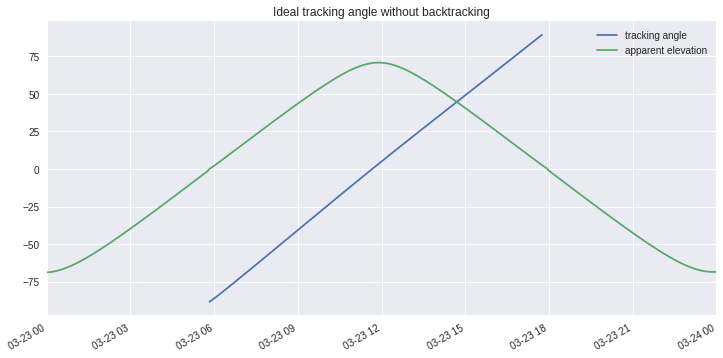

In [16]:
tmp = np.degrees(np.arctan(zp/xp))  # angle from x-y plane to projection of sun vector onto x-z plane

# Obtain wid by translating tmp to convention for rotation angles.
# Have to account for which quadrant of the x-z plane in which the sun 
# vector lies.  Complete solution here but probably not necessary to 
# consider QIII and QIV.
wid = pd.Series(index=times)
wid[(xp>=0) & (zp>=0)] =  90 - tmp[(xp>=0) & (zp>=0)];  # QI
wid[(xp<0)  & (zp>=0)] = -90 - tmp[(xp<0)  & (zp>=0)];  # QII
wid[(xp<0)  & (zp<0)]  = -90 - tmp[(xp<0)  & (zp<0)];   # QIII
wid[(xp>=0) & (zp<0)]  =  90 - tmp[(xp>=0) & (zp<0)];   # QIV

# filter for sun above panel horizon
wid[zp <= 0] = np.nan

wid.plot(label='tracking angle')
ephemout['apparent_elevation'].plot(label='apparent elevation')
plt.legend()
plt.title('Ideal tracking angle without backtracking')

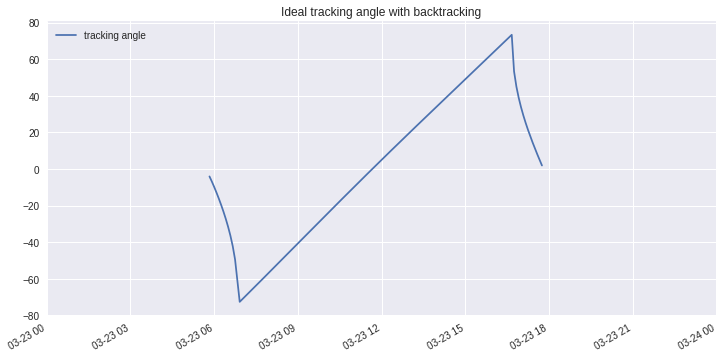

In [17]:
if backtrack:
    axes_distance = 1/gcr
    temp = np.minimum(axes_distance*cosd(wid), 1)

    # backtrack angle
    # (always positive b/c acosd returns values between 0 and 180)
    wc = np.degrees(np.arccos(temp))

    v = wid < 0
    widc = pd.Series(index=times)
    widc[~v] = wid[~v] - wc[~v]; # Eq 4 applied when wid in QI
    widc[v] = wid[v] + wc[v];    # Eq 4 applied when wid in QIV
else:
    widc = wid

widc.plot(label='tracking angle')
#pyephemout['apparent_elevation'].plot(label='apparent elevation')
plt.legend(loc=2)
plt.title('Ideal tracking angle with backtracking')

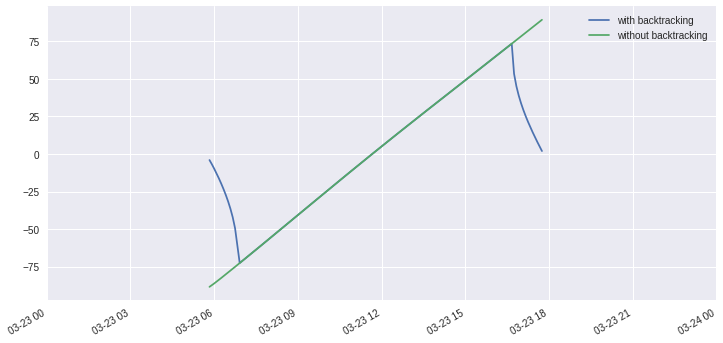

In [18]:
tracking_angles = pd.DataFrame({'with backtracking':widc,'without backtracking':wid})
tracking_angles.plot()
#pyephemout['apparent_elevation'].plot(label='apparent elevation')
plt.legend()

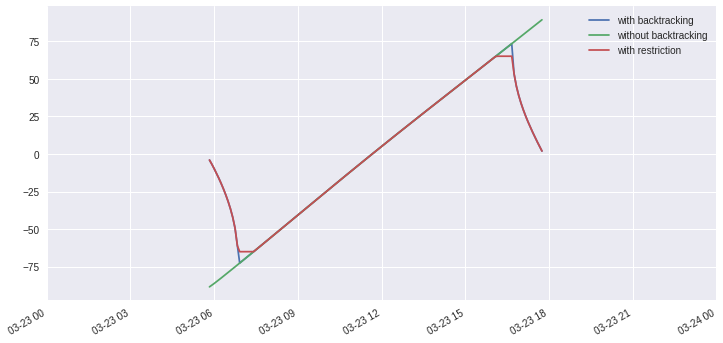

In [19]:
tracker_theta = widc.copy()
tracker_theta[tracker_theta > max_angle] = max_angle
tracker_theta[tracker_theta < -max_angle] = -max_angle

tracking_angles['with restriction'] = tracker_theta
tracking_angles.plot()

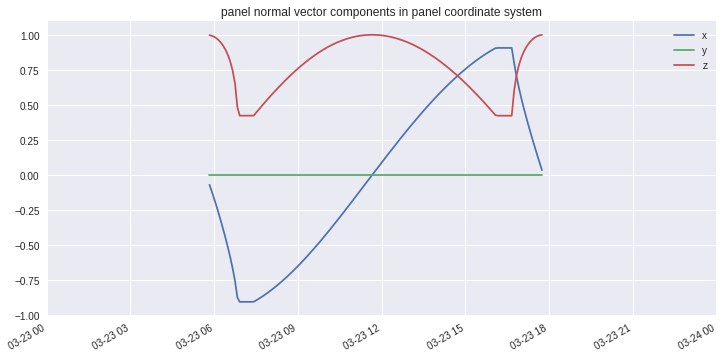

In [20]:
panel_norm = np.array([sind(tracker_theta), 
                       tracker_theta*0,
                       cosd(tracker_theta)])

panel_norm_df = pd.DataFrame(panel_norm.T, columns=('x','y','z'), index=times)
panel_norm_df.plot()
plt.title('panel normal vector components in panel coordinate system')
plt.legend()

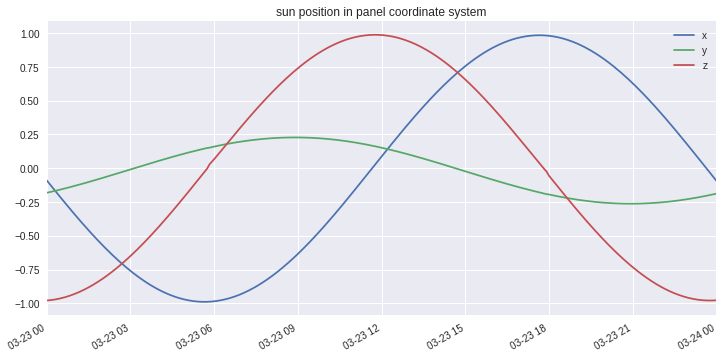

In [22]:
sun_vec = np.array([xp, yp, zp])

panel_coords = pd.DataFrame(sun_vec.T, columns=('x','y','z'), index=times)

panel_coords.plot()
plt.title('sun position in panel coordinate system')

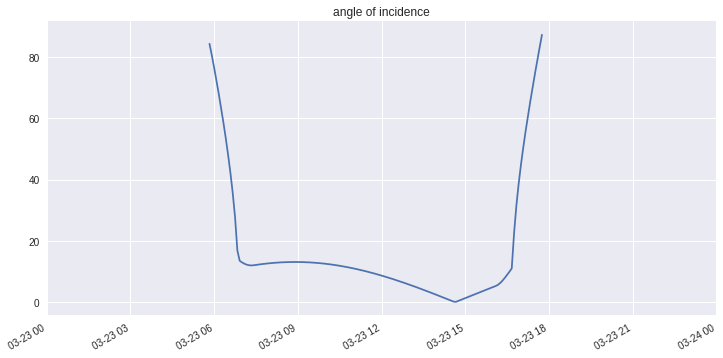

In [23]:
aoi = np.degrees(np.arccos(np.abs(np.sum(sun_vec*panel_norm, axis=0))))
aoi = pd.Series(aoi, index=times)

aoi.plot()
plt.title('angle of incidence')

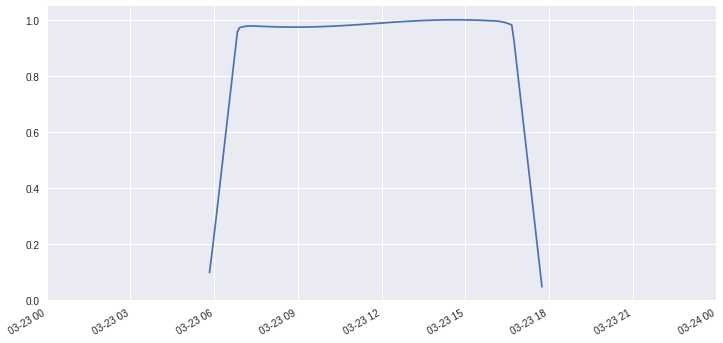

In [24]:
cosd(aoi).plot()

cos(axis_azimuth_south)=0.984807753012208, sin(axis_azimuth_south)=-0.17364817766693033
cos(axis_tilt)=0.984807753012208, sin(axis_tilt)=0.17364817766693033


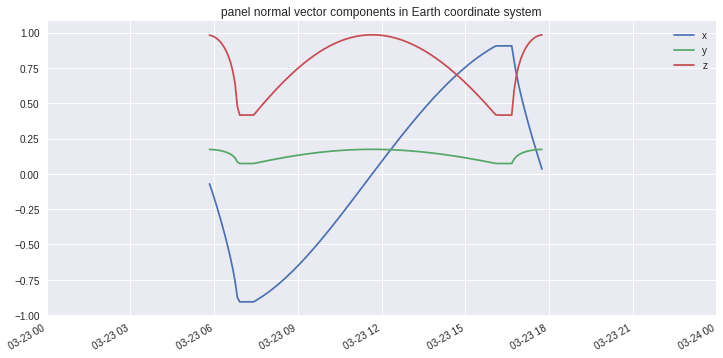

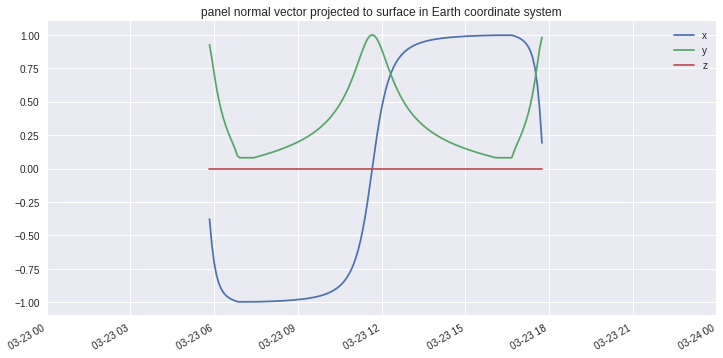

In [25]:
# Calculate standard rotation matrix
print('cos(axis_azimuth_south)={}, sin(axis_azimuth_south)={}'
      .format(cosd(axis_azimuth_south), sind(axis_azimuth_south)))
print('cos(axis_tilt)={}, sin(axis_tilt)={}'
      .format(cosd(axis_tilt), sind(axis_tilt)))

rot_x = np.array([[1, 0, 0], 
                  [0, cosd(-axis_tilt), -sind(-axis_tilt)], 
                  [0, sind(-axis_tilt), cosd(-axis_tilt)]])

# panel_norm_earth contains the normal vector expressed in earth-surface coordinates
# (z normal to surface, y aligned with tracker axis parallel to earth)
panel_norm_earth = np.dot(rot_x, panel_norm).T

# projection to plane tangent to earth surface,
# in earth surface coordinates
projected_normal = np.array([panel_norm_earth[:,0], panel_norm_earth[:,1], panel_norm_earth[:,2]*0]).T

# calculate magnitudes
panel_norm_earth_mag = np.sqrt(np.nansum(panel_norm_earth**2, axis=1))
projected_normal_mag = np.sqrt(np.nansum(projected_normal**2, axis=1))
#print('panel_norm_earth_mag={}, projected_normal_mag={}'.format(panel_norm_earth_mag, projected_normal_mag))

projected_normal = (projected_normal.T / projected_normal_mag).T

panel_norm_earth_df = pd.DataFrame(panel_norm_earth, columns=('x','y','z'), index=times)
panel_norm_earth_df.plot()
plt.title('panel normal vector components in Earth coordinate system')

projected_normal_df = pd.DataFrame(projected_normal, columns=('x','y','z'), index=times)
projected_normal_df.plot()
plt.title('panel normal vector projected to surface in Earth coordinate system')

In [26]:
from pvlib import pvsystem

In [27]:

pvlib_abspath = os.path.dirname(os.path.abspath(inspect.getfile(pvlib)))

tmy3_data, tmy3_metadata = pvlib.tmy.readtmy3(os.path.join(pvlib_abspath, 'data', '703165TY.csv'))
tmy2_data, tmy2_metadata = pvlib.tmy.readtmy2(os.path.join(pvlib_abspath, 'data', '12839.tm2'))
pvlib.pvsystem.systemdef(tmy3_metadata, 0, 0, .1, 5, 5)

{'albedo': 0.1,
 'altitude': 7.0,
 'latitude': 55.317,
 'longitude': -160.517,
 'modules_per_string': 5,
 'name': '"SAND POINT"',
 'strings_per_inverter': 5,
 'surface_azimuth': 0,
 'surface_tilt': 0,
 'tz': -9.0}

In [28]:
pvlib.pvsystem.systemdef(tmy2_metadata, 0, 0, .1, 5, 5)

{'albedo': 0.1,
 'altitude': 2.0,
 'latitude': 25.8,
 'longitude': -80.26666666666667,
 'modules_per_string': 5,
 'name': 'MIAMI',
 'strings_per_inverter': 5,
 'surface_azimuth': 0,
 'surface_tilt': 0,
 'tz': -5}

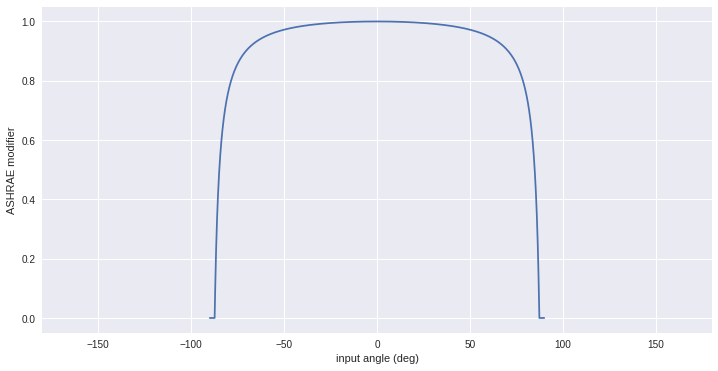

In [29]:
angles = np.linspace(-180,180,3601)
ashraeiam = pd.Series(pvsystem.ashraeiam(angles, .05), index=angles)

ashraeiam.plot()
plt.ylabel('ASHRAE modifier')
plt.xlabel('input angle (deg)')

/home/acer/anaconda3/lib/python3.6/site-packages/pvlib/pvsystem.py:811: RuntimeWarning: invalid value encountered in true_divide
  ((tools.sind(thetar_deg + aoi)) ** 2) +
/home/acer/anaconda3/lib/python3.6/site-packages/pvlib/pvsystem.py:813: RuntimeWarning: invalid value encountered in true_divide
  ((tools.tand(thetar_deg + aoi)) ** 2))))))
/home/acer/anaconda3/lib/python3.6/site-packages/pvlib/pvsystem.py:827: RuntimeWarning: invalid value encountered in less
  iam = np.where((np.abs(aoi) >= 90) | (iam < 0), np.nan, iam)


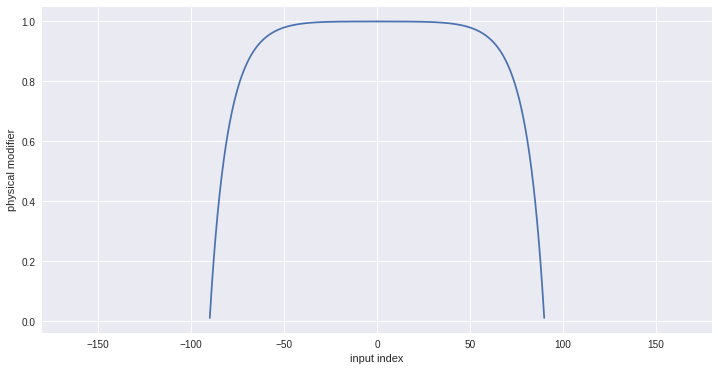

In [30]:
angles = np.linspace(-180,180,3601)
physicaliam = pd.Series(pvsystem.physicaliam(angles), index=angles)

physicaliam.plot()
plt.ylabel('physical modifier')
plt.xlabel('input index')

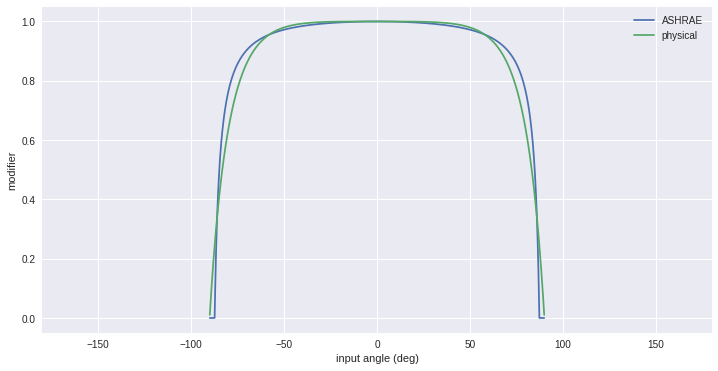

In [31]:
plt.figure()
ashraeiam.plot(label='ASHRAE')
physicaliam.plot(label='physical')
plt.ylabel('modifier')
plt.xlabel('input angle (deg)')
plt.legend()

In [32]:
pvsystem.sapm_celltemp(900, 5, 20) # irrad, wind, temp

,temp_cell,temp_module
0,43.509191,40.809191


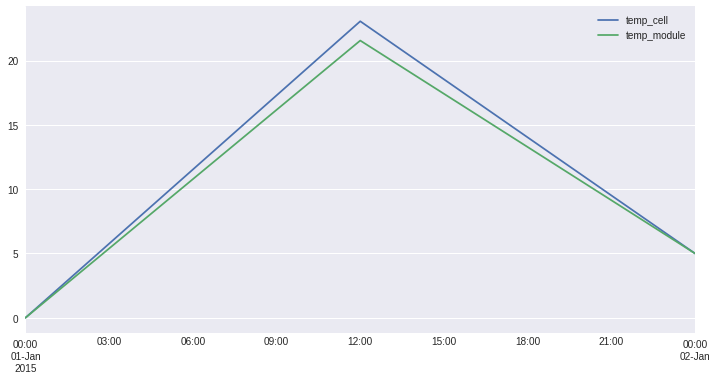

In [33]:
times = pd.DatetimeIndex(start='2015-01-01', end='2015-01-02', freq='12H')
temps = pd.Series([0, 10, 5], index=times)
irrads = pd.Series([0, 500, 0], index=times)
winds = pd.Series([10, 5, 0], index=times)

pvtemps = pvsystem.sapm_celltemp(irrads, winds, temps)
pvtemps.plot()

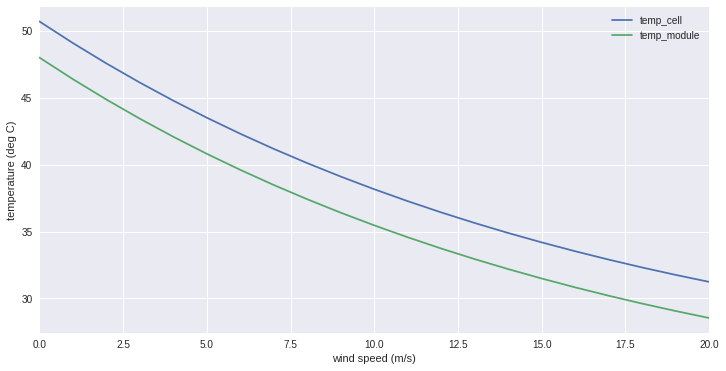

In [34]:

wind = np.linspace(0,20,21)
temps = pd.DataFrame(pvsystem.sapm_celltemp(900, wind, 20), index=wind)

temps.plot()
plt.legend()
plt.xlabel('wind speed (m/s)')
plt.ylabel('temperature (deg C)')

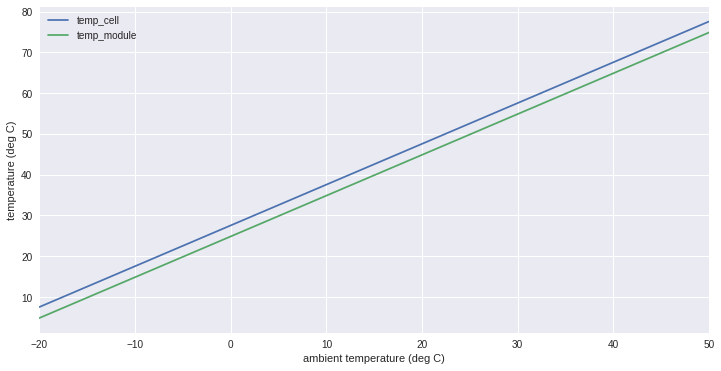

In [35]:
atemp = np.linspace(-20,50,71)
temps = pvsystem.sapm_celltemp(900, 2, atemp).set_index(atemp)

temps.plot()
plt.legend()
plt.xlabel('ambient temperature (deg C)')
plt.ylabel('temperature (deg C)')

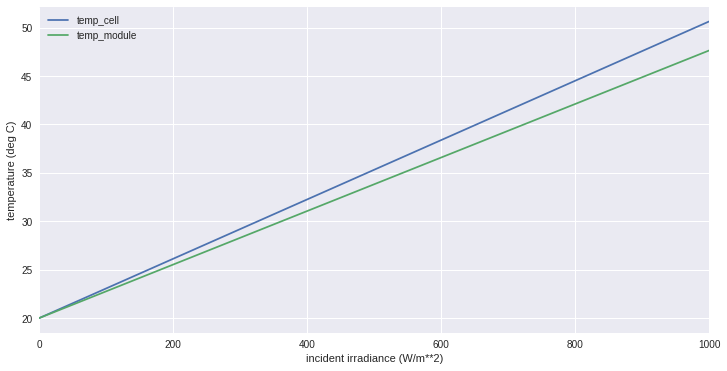

In [36]:
irrad = np.linspace(0,1000,101)
temps = pvsystem.sapm_celltemp(irrad, 2, 20).set_index(irrad)

temps.plot()
plt.legend()
plt.xlabel('incident irradiance (W/m**2)')
plt.ylabel('temperature (deg C)')


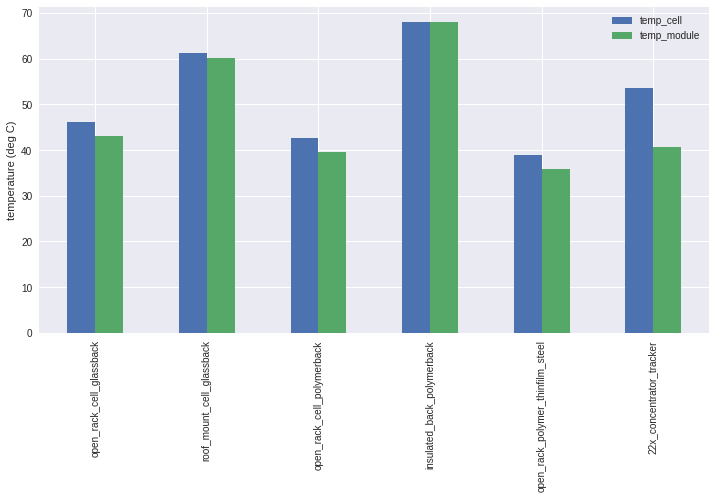

In [37]:
models = ['open_rack_cell_glassback',
          'roof_mount_cell_glassback',
          'open_rack_cell_polymerback',
          'insulated_back_polymerback',
          'open_rack_polymer_thinfilm_steel',
          '22x_concentrator_tracker']

temps = pd.DataFrame(index=['temp_cell','temp_module'])

for model in models:
    temps[model] = pd.Series(pvsystem.sapm_celltemp(1000, 5, 20, model=model).ix[0])

temps.T.plot(kind='bar') # try removing the transpose operation and replotting
plt.legend()
plt.ylabel('temperature (deg C)')

In [38]:
inverters = pvsystem.retrieve_sam('sandiainverter')
inverters

,ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_,ABB__MICRO_0_25_I_OUTD_US_240_240V__CEC_2014_,ABB__MICRO_0_3HV_I_OUTD_US_208_208V__CEC_2014_,ABB__MICRO_0_3HV_I_OUTD_US_240_240V__CEC_2014_,ABB__MICRO_0_3_I_OUTD_US_208_208V__CEC_2014_,ABB__MICRO_0_3_I_OUTD_US_240_240V__CEC_2014_,ABB__PVI_3_0_OUTD_S_US_Z_M_A__208_V__208V__CEC_2014_,ABB__PVI_3_0_OUTD_S_US_Z_M_A__240_V__240V__CEC_2014_,ABB__PVI_3_0_OUTD_S_US_Z_M_A__277_V__277V__CEC_2014_,ABB__PVI_3_6_OUTD_S_US_Z_M__208_V__208V__CEC_2014_,...,Yes!_Solar_Inc___ES5000__240V__240V__CEC_2009_,Yes!_Solar_Inc___ES5300__208V__208V__CEC_2009_,Yes!_Solar_Inc___ES5300__240V__240V__CEC_2009_,Zhejiang_Yuhui_Solar_Energy_Source__Replus_250A_240V__CEC_2012_,Zhejiang_Yuhui_Solar_Energy_Source__Replus_250B_208V__CEC_2012_,Zigor__Sunzet_2_TL_US_240V__CEC_2011_,Zigor__Sunzet_3_TL_US_240V__CEC_2011_,Zigor__Sunzet_4_TL_US_240V__CEC_2011_,Zigor__Sunzet_5_TL_US_240V__CEC_2011_,Zigor__SUNZET4_USA_240V__CEC_2011_
Vac,208.000000,240.000000,208.000000,240.000000,208.000000,240.000000,208.000000,240.000000,277.000000,208.000000,...,240.000000,208.000000,240.000000,2.400000e+02,208.000000,240.000000,240.000000,240.000000,240.000000,240.000000
Paco,250.000000,250.000000,300.000000,300.000000,300.000000,300.000000,3000.000000,3000.000000,3000.000000,3600.000000,...,4900.000000,4600.000000,5300.000000,2.251900e+02,213.830000,2110.000000,3180.000000,4160.000000,5240.000000,4030.000000
Pdco,259.522050,259.552697,312.523347,312.022059,311.714554,311.504961,3147.009528,3125.758222,3110.342942,3759.288140,...,5135.584132,4829.422409,5571.180956,2.348419e+02,225.563055,2191.825129,3313.675805,4342.409314,5495.829926,4267.477069
Vdco,40.242603,39.982246,45.259429,45.495009,40.227111,40.136095,313.429286,340.842937,389.986270,309.948254,...,275.000000,275.000000,274.900000,2.846843e+01,28.632617,399.207333,389.513254,388.562050,386.082539,302.851707
Pso,1.771614,1.931194,1.882620,1.928591,1.971053,1.991342,18.104122,19.866112,22.720135,24.202212,...,29.358943,26.071506,28.519033,1.646711e+00,1.845029,30.843703,31.265046,31.601704,32.450808,37.372766
C0,-0.000025,-0.000027,-0.000049,-0.000035,-0.000036,-0.000031,-0.000009,-0.000007,-0.000006,-0.000005,...,-0.000006,-0.000006,-0.000006,-3.860000e-07,-0.000121,-0.000004,-0.000006,-0.000004,-0.000005,-0.000009
C1,-0.000090,-0.000158,-0.000241,-0.000228,-0.000256,-0.000289,-0.000012,-0.000025,-0.000044,0.000002,...,0.000020,0.000024,0.000019,-3.580000e-04,-0.000533,-0.000077,-0.000095,-0.000079,-0.000097,-0.000029
C2,0.000669,0.001480,0.000975,-0.000224,-0.000833,-0.002110,0.001620,0.001050,0.000036,0.001730,...,0.001870,0.002620,0.001630,-1.350000e-02,0.025900,0.000502,0.000261,0.000213,-0.000251,0.002150
C3,-0.018900,-0.034600,-0.027600,-0.039600,-0.039100,-0.049500,-0.000217,-0.000471,-0.001550,0.001140,...,-0.000276,0.000468,-0.000371,-3.350684e+01,-0.066800,-0.003260,-0.001960,-0.001870,-0.002340,-0.001900
Pnt,0.020000,0.050000,0.060000,0.060000,0.020000,0.050000,0.100000,0.100000,0.200000,0.100000,...,0.500000,0.500000,0.500000,1.700000e-01,0.170000,0.250000,0.250000,0.200000,0.200000,0.190000


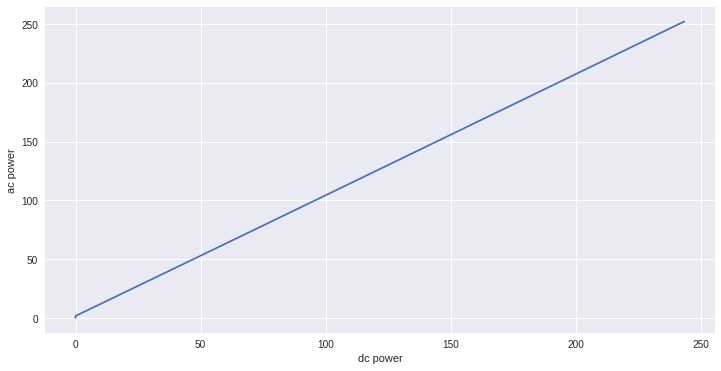

In [39]:
vdcs = pd.Series(np.linspace(0,50,51))
idcs = pd.Series(np.linspace(0,11,110))
pdcs = idcs * vdcs

pacs = pvsystem.snlinverter(vdcs, pdcs, inverters['ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_'])
#pacs.plot()
plt.plot(pacs, pdcs)
plt.ylabel('ac power')
plt.xlabel('dc power')

In [40]:
cec_modules = pvsystem.retrieve_sam('cecmod')
cec_modules

,BEoptCA_Default_Module,Example_Module,1Soltech_1STH_215_P,1Soltech_1STH_220_P,1Soltech_1STH_225_P,1Soltech_1STH_230_P,1Soltech_1STH_235_WH,1Soltech_1STH_240_WH,1Soltech_1STH_245_WH,1Soltech_1STH_FRL_4H_245_M60_BLK,...,Zytech_Solar_ZT275P,Zytech_Solar_ZT280P,Zytech_Solar_ZT285P,Zytech_Solar_ZT290P,Zytech_Solar_ZT295P,Zytech_Solar_ZT300P,Zytech_Solar_ZT305P,Zytech_Solar_ZT310P,Zytech_Solar_ZT315P,Zytech_Solar_ZT320P
BIPV,Y,Y,N,N,N,N,N,N,N,N,...,N,N,N,N,N,N,N,N,N,N
Date,12/17/2008,4/28/2008,10/7/2010,10/4/2010,10/4/2010,10/4/2010,3/4/2010,3/4/2010,3/4/2010,1/14/2013,...,12/23/2014,12/23/2014,12/23/2014,12/23/2014,12/23/2014,12/23/2014,12/23/2014,12/23/2014,12/23/2014,12/23/2014
T_NOCT,65,65,47.4,47.4,47.4,47.4,49.9,49.9,49.9,48.3,...,46.4,46.4,46.4,46.4,46.4,46.4,46.4,46.4,46.4,46.4
A_c,0.67,0.67,1.567,1.567,1.567,1.567,1.635,1.635,1.635,1.668,...,1.931,1.931,1.931,1.931,1.931,1.931,1.931,1.931,1.931,1.931
N_s,18,18,60,60,60,60,60,60,60,60,...,72,72,72,72,72,72,72,72,72,72
I_sc_ref,7.5,7.5,7.84,7.97,8.09,8.18,8.54,8.58,8.62,8.81,...,8.31,8.4,8.48,8.55,8.64,8.71,8.87,8.9,9.01,9.12
V_oc_ref,10.4,10.4,36.3,36.6,36.9,37.1,37,37.1,37.2,38.3,...,45.1,45.25,45.43,45.59,45.75,45.96,46.12,46.28,46.44,46.6
I_mp_ref,6.6,6.6,7.35,7.47,7.58,7.65,8.02,8.07,8.1,8.06,...,7.76,7.87,7.97,8.07,8.16,8.26,8.36,8.46,8.56,8.66
V_mp_ref,8.4,8.4,29,29.3,29.6,29.9,29.3,29.7,30.2,30.2,...,35.44,35.62,35.8,35.94,36.16,36.32,36.49,36.66,36.81,37
alpha_sc,0.003,0.003,0.007997,0.008129,0.008252,0.008344,0.00743,0.007465,0.007499,0.006167,...,0.004014,0.004057,0.004096,0.00413,0.004173,0.004207,0.004284,0.004299,0.004352,0.004405


In [41]:
cecmodule = cec_modules.Example_Module 
cecmodule

BIPV                   Y
Date           4/28/2008
T_NOCT                65
A_c                 0.67
N_s                   18
I_sc_ref             7.5
V_oc_ref            10.4
I_mp_ref             6.6
V_mp_ref             8.4
alpha_sc           0.003
beta_oc            -0.04
a_ref              0.473
I_L_ref            7.545
I_o_ref        1.943e-09
R_s                0.094
R_sh_ref           15.72
Adjust              10.6
gamma_r             -0.5
Version            MM105
PTC                 48.9
Technology    Multi-c-Si
Name: Example_Module, dtype: object

In [42]:

sandia_modules = pvsystem.retrieve_sam(name='SandiaMod')
sandia_modules

,Advent_Solar_AS160___2006_,Advent_Solar_Ventura_210___2008_,Advent_Solar_Ventura_215___2009_,Aleo_S03_160__2007__E__,Aleo_S03_165__2007__E__,Aleo_S16_165__2007__E__,Aleo_S16_170__2007__E__,Aleo_S16_175__2007__E__,Aleo_S16_180__2007__E__,Aleo_S16_185__2007__E__,...,Panasonic_VBHN235SA06B__2013_,Trina_TSM_240PA05__2013_,Hanwha_HSL60P6_PA_4_250T__2013_,Suniva_OPT300_72_4_100__2013_,Canadian_Solar_CS6X_300M__2013_,LG_LG290N1C_G3__2013_,Sharp_NDQ235F4__2013_,Solar_Frontier_SF_160S__2013_,SolarWorld_Sunmodule_250_Poly__2013_,Silevo_Triex_U300_Black__2014_
Vintage,2006,2008,2009,2007 (E),2007 (E),2007 (E),2007 (E),2007 (E),2007 (E),2007 (E),...,2013,2013,2013,2013,2013,2013,2013,2013,2013,2014
Area,1.312,1.646,1.646,1.28,1.28,1.378,1.378,1.378,1.378,1.378,...,1.26,1.63,1.65,1.93,1.91,1.64,1.56,1.22,1.68,1.68
Material,mc-Si,mc-Si,mc-Si,c-Si,c-Si,mc-Si,mc-Si,mc-Si,mc-Si,mc-Si,...,a-Si / mono-Si,mc-Si,mc-Si,c-Si,c-Si,c-Si,mc-Si,CIS,mc-Si,c-Si
Cells_in_Series,72,60,60,72,72,50,50,50,50,50,...,72,60,60,72,72,60,60,172,60,96
Parallel_Strings,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Isco,5.564,8.34,8.49,5.1,5.2,7.9,7.95,8.1,8.15,8.2,...,5.8738,8.8449,8.5935,8.5753,8.6388,9.8525,8.6739,2.0259,8.3768,5.771
Voco,42.832,35.31,35.92,43.5,43.6,30,30.1,30.2,30.3,30.5,...,52.0042,36.8926,36.8075,44.2921,43.5918,39.6117,36.8276,112.505,36.3806,68.5983
Impo,5.028,7.49,7.74,4.55,4.65,7.08,7.23,7.38,7.53,7.67,...,5.5383,8.2955,8.0822,7.963,8.1359,9.2473,8.1243,1.8356,7.6921,5.383
Vmpo,32.41,27.61,27.92,35.6,35.8,23.3,23.5,23.7,23.9,24.1,...,43.1204,29.066,29.2011,35.0837,34.9531,31.2921,29.1988,86.6752,28.348,55.4547
Aisc,0.000537,0.00077,0.00082,0.0003,0.0003,0.0008,0.0008,0.0008,0.0008,0.0008,...,0.0005,0.0004,0.0004,0.0006,0.0005,0.0002,0.0006,0.0001,0.0006,0.0003


In [43]:
sandia_module = sandia_modules.Canadian_Solar_CS5P_220M___2009_
sandia_module

Vintage                                                          2009
Area                                                            1.701
Material                                                         c-Si
Cells_in_Series                                                    96
Parallel_Strings                                                    1
Isco                                                          5.09115
Voco                                                          59.2608
Impo                                                          4.54629
Vmpo                                                          48.3156
Aisc                                                         0.000397
Aimp                                                         0.000181
C0                                                            1.01284
C1                                                         -0.0128398
Bvoco                                                        -0.21696
Mbvoc               

In [44]:

from pvlib import clearsky
from pvlib import irradiance
from pvlib import atmosphere
from pvlib.location import Location

tus = Location(32.2, -111, 'US/Arizona', 700, 'Tucson')

times_loc = pd.date_range(start=datetime.datetime(2014,4,1), end=datetime.datetime(2014,4,2), freq='30s', tz=tus.tz)
solpos = pvlib.solarposition.get_solarposition(times_loc, tus.latitude, tus.longitude)
dni_extra = pvlib.irradiance.extraradiation(times_loc)
airmass = pvlib.atmosphere.relativeairmass(solpos['apparent_zenith'])
pressure = pvlib.atmosphere.alt2pres(tus.altitude)
am_abs = pvlib.atmosphere.absoluteairmass(airmass, pressure)
cs = tus.get_clearsky(times_loc)

surface_tilt = tus.latitude
surface_azimuth = 180  # pointing south

aoi = pvlib.irradiance.aoi(surface_tilt, surface_azimuth,
                           solpos['apparent_zenith'], solpos['azimuth'])
total_irrad = pvlib.irradiance.total_irrad(surface_tilt,
                                           surface_azimuth,
                                           solpos['apparent_zenith'],
                                           solpos['azimuth'],
                                           cs['dni'], cs['ghi'], cs['dhi'],
                                           dni_extra=dni_extra,
                                           model='haydavies')

/home/acer/anaconda3/lib/python3.6/site-packages/pvlib/pvsystem.py:1283: RuntimeWarning: divide by zero encountered in log
  module['Voco'] + module['Cells_in_Series']*delta*np.log(Ee) +
/home/acer/anaconda3/lib/python3.6/site-packages/pvlib/pvsystem.py:1289: RuntimeWarning: divide by zero encountered in log
  module['C3']*module['Cells_in_Series']*((delta*np.log(Ee)) ** 2) +


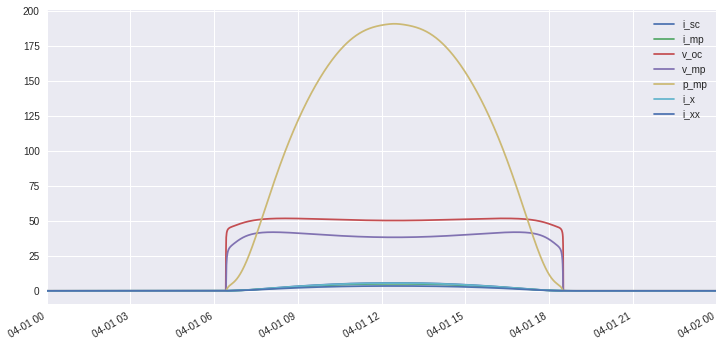

In [45]:
module = sandia_module

# a sunny, calm, and hot day in the desert
temps = pvsystem.sapm_celltemp(total_irrad['poa_global'], 0, 30)

effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
    total_irrad['poa_direct'], total_irrad['poa_diffuse'],
    am_abs, aoi, module)

sapm_1 = pvlib.pvsystem.sapm(effective_irradiance, temps['temp_cell'], module)

sapm_1.plot()

In [46]:

def plot_sapm(sapm_data, effective_irradiance):
    """
    Makes a nice figure with the SAPM data.
    
    Parameters
    ----------
    sapm_data : DataFrame
        The output of ``pvsystem.sapm``
    """
    fig, axes = plt.subplots(2, 3, figsize=(16,10), sharex=False, sharey=False, squeeze=False)
    plt.subplots_adjust(wspace=.2, hspace=.3)

    ax = axes[0,0]
    sapm_data.filter(like='i_').plot(ax=ax)
    ax.set_ylabel('Current (A)')

    ax = axes[0,1]
    sapm_data.filter(like='v_').plot(ax=ax)
    ax.set_ylabel('Voltage (V)')

    ax = axes[0,2]
    sapm_data.filter(like='p_').plot(ax=ax)
    ax.set_ylabel('Power (W)')

    ax = axes[1,0]
    [ax.plot(effective_irradiance, current, label=name) for name, current in
     sapm_data.filter(like='i_').iteritems()]
    ax.set_ylabel('Current (A)')
    ax.set_xlabel('Effective Irradiance')
    ax.legend(loc=2)

    ax = axes[1,1]
    [ax.plot(effective_irradiance, voltage, label=name) for name, voltage in
     sapm_data.filter(like='v_').iteritems()]
    ax.set_ylabel('Voltage (V)')
    ax.set_xlabel('Effective Irradiance')
    ax.legend(loc=4)

    ax = axes[1,2]
    ax.plot(effective_irradiance, sapm_data['p_mp'], label='p_mp')
    ax.set_ylabel('Power (W)')
    ax.set_xlabel('Effective Irradiance')
    ax.legend(loc=2)

    # needed to show the time ticks
    for ax in axes.flatten():
        for tk in ax.get_xticklabels():
            tk.set_visible(True)

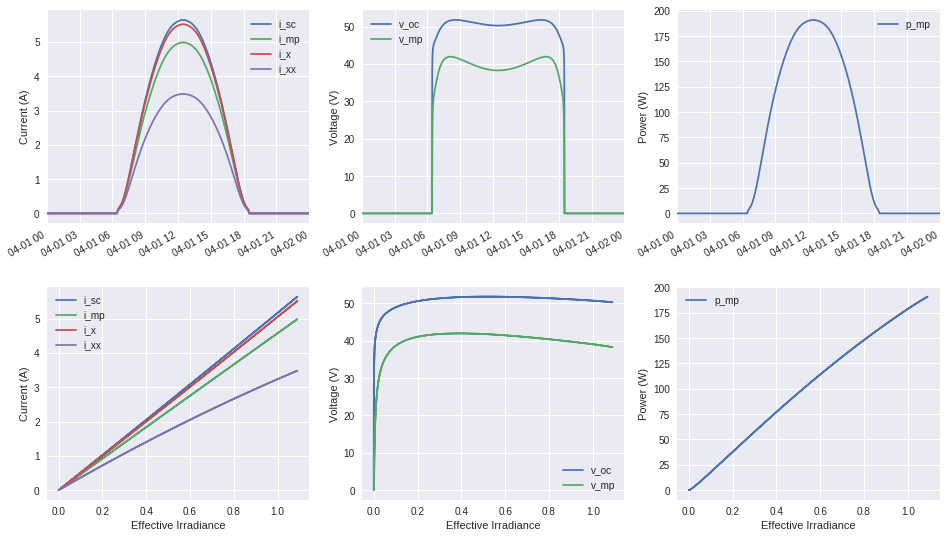

In [47]:

plot_sapm(sapm_1, effective_irradiance)


/home/acer/anaconda3/lib/python3.6/site-packages/pvlib/pvsystem.py:1283: RuntimeWarning: divide by zero encountered in log
  module['Voco'] + module['Cells_in_Series']*delta*np.log(Ee) +
/home/acer/anaconda3/lib/python3.6/site-packages/pvlib/pvsystem.py:1289: RuntimeWarning: divide by zero encountered in log
  module['C3']*module['Cells_in_Series']*((delta*np.log(Ee)) ** 2) +


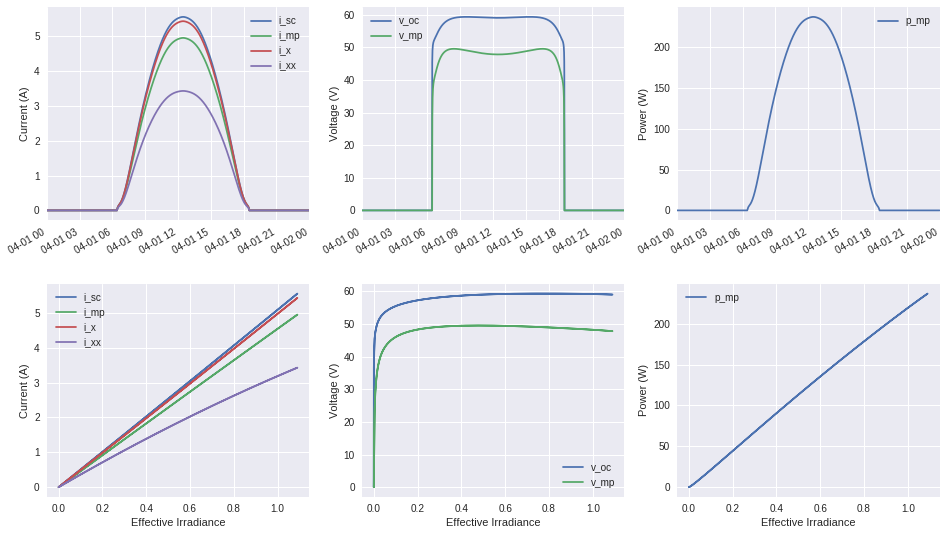

In [48]:
temps = pvsystem.sapm_celltemp(total_irrad['poa_global'], 10, 5)

sapm_2 = pvlib.pvsystem.sapm(effective_irradiance, temps['temp_cell'], module)

plot_sapm(sapm_2, effective_irradiance)

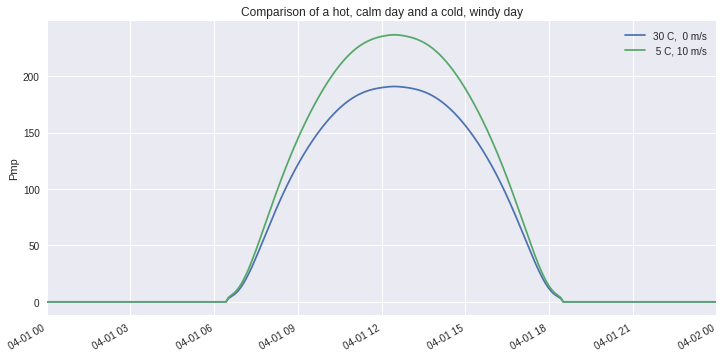

In [49]:

sapm_1['p_mp'].plot(label='30 C,  0 m/s')
sapm_2['p_mp'].plot(label=' 5 C, 10 m/s')
plt.legend()
plt.ylabel('Pmp')
plt.title('Comparison of a hot, calm day and a cold, windy day')

In [50]:
import warnings
warnings.simplefilter('ignore', np.RankWarning)

In [51]:
def sapm_to_ivframe(sapm_row):
    pnt = sapm_row.T.ix[:,0]

    ivframe = {'Isc': (pnt['i_sc'], 0),
              'Pmp': (pnt['i_mp'], pnt['v_mp']),
              'Ix': (pnt['i_x'], 0.5*pnt['v_oc']),
              'Ixx': (pnt['i_xx'], 0.5*(pnt['v_oc']+pnt['v_mp'])),
              'Voc': (0, pnt['v_oc'])}
    ivframe = pd.DataFrame(ivframe, index=['current', 'voltage']).T
    ivframe = ivframe.sort_values(by='voltage')
    
    return ivframe

def ivframe_to_ivcurve(ivframe, points=100):
    ivfit_coefs = np.polyfit(ivframe['voltage'], ivframe['current'], 30)
    fit_voltages = np.linspace(0, ivframe.ix['Voc', 'voltage'], points)
    fit_currents = np.polyval(ivfit_coefs, fit_voltages)
    
    return fit_voltages, fit_currents

In [52]:

sapm_to_ivframe(sapm_1['2014-04-01 10:00:00'])

,current,voltage
Isc,4.469275,0.000000
Ix,4.366101,25.595191
Pmp,3.968336,39.980851
Ixx,2.856893,45.585617
Voc,0.000000,51.190382


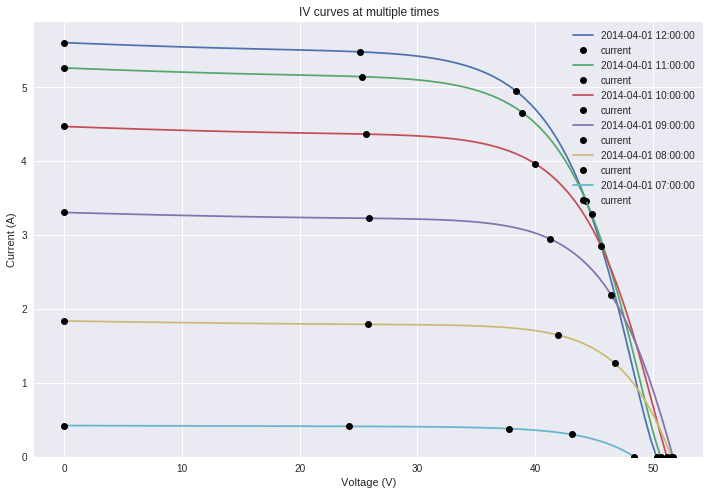

In [53]:
times = ['2014-04-01 07:00:00', '2014-04-01 08:00:00', '2014-04-01 09:00:00', 
         '2014-04-01 10:00:00', '2014-04-01 11:00:00', '2014-04-01 12:00:00']
times.reverse()

fig, ax = plt.subplots(1, 1, figsize=(12,8))

for time in times:
    ivframe = sapm_to_ivframe(sapm_1[time])

    fit_voltages, fit_currents = ivframe_to_ivcurve(ivframe)

    ax.plot(fit_voltages, fit_currents, label=time)
    ax.plot(ivframe['voltage'], ivframe['current'], 'ko')
    
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Current (A)')
ax.set_ylim(0, None)
ax.set_title('IV curves at multiple times')
ax.legend()

In [54]:
photocurrent, saturation_current, resistance_series, resistance_shunt, nNsVth = (
    pvsystem.calcparams_desoto(total_irrad['poa_global'],
                                 temp_cell=temps['temp_cell'],
                                 alpha_isc=cecmodule['alpha_sc'],
                                 module_parameters=cecmodule,
                                 EgRef=1.121,
                                 dEgdT=-0.0002677) )

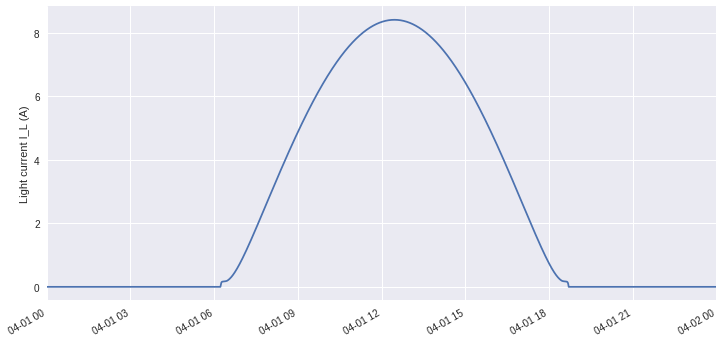

In [55]:
photocurrent.plot()
plt.ylabel('Light current I_L (A)')

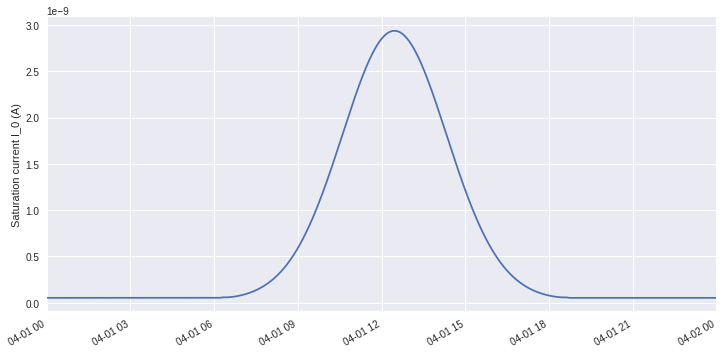

In [56]:
saturation_current.plot()
plt.ylabel('Saturation current I_0 (A)')

In [57]:

resistance_series

0.094

(0, 100)

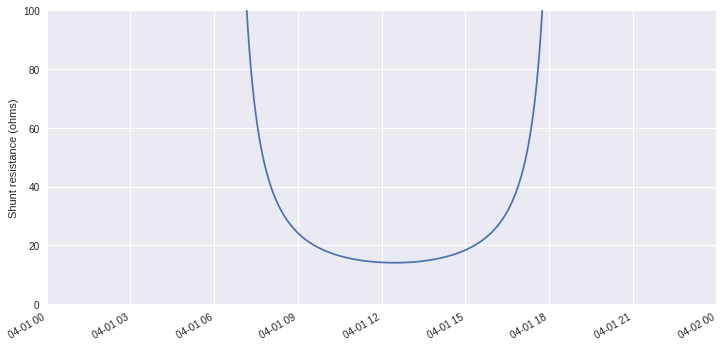

In [58]:
resistance_shunt.plot()
plt.ylabel('Shunt resistance (ohms)')
plt.ylim(0,100)

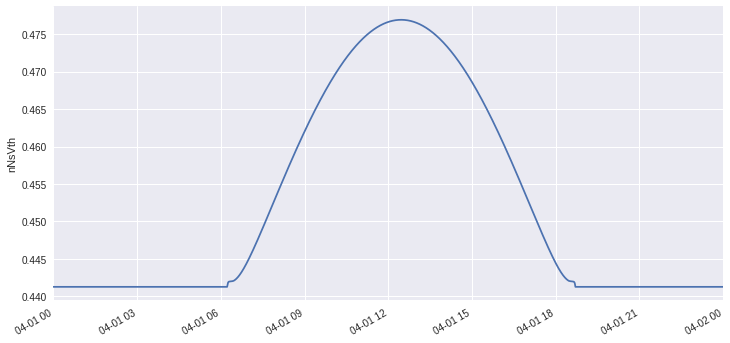

In [59]:
nNsVth.plot()
plt.ylabel('nNsVth')